In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os

EVALUATION_FOLDER = "final_evaluation_minbzk"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_minbzk_real_words_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_real_words_minbzk_real_words_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_keywords_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_paraphrase_BM25S.csv"
# RESULTS_FILE = "evaluation_minbzk_no_requests_stem_stopwords_minbzk_real_words_BM25S.csv"

RESULTS_FILE_1 = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
RESULTS_FILE_2 = "evaluation_minbzk_no_requests_minbzk_paraphrase_bert-base-dutch-cased.csv"
RESULTS_FILE_3 = "evaluation_minbzk_no_requests_minbzk_all-MiniLM-L6-v2.csv"

SAVE_FOLDER = os.path.join("final_plots", "minbzk")
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

woo_data_1 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_1}")
woo_data_2 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_2}")
woo_data_3 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_3}")

In [2]:
def process_map(woo_data, n):
    """
    Where n is the number of pages retrieved (max 100).
    """
    results_summary = []
    # thresholds = [i/100 for i in range(101)]
    # Create 100 steps between 0 and 0.1
    thresholds = [i * 0.0001 for i in range(1000)]

    # Add values 0.2, 0.3, ..., up to 1
    thresholds.extend([i * 0.1 for i in range(2, 11)])

    for threshold in thresholds:
        headers = ['dossier_id', 'retrieved_document_ids', 'confidences', 'retrieved_document_ids_above_threshold', 'confusion_category']
        df = pd.DataFrame(columns=headers)

        for index, row in woo_data.iterrows():
            document_ids = row["retrieved_document_ids"].split(", ")[:n]
            unique_document_ids_set = set(document_ids)
            unique_document_ids_dict = {key: 0 for key in unique_document_ids_set}
            # If only 1 document has been retrieved, set confidence to 1
            if len(unique_document_ids_dict) <= 1:
                # Set confidence to 1
                result = {key: 1 for key in unique_document_ids_dict}
            else:
                # Iterate over the dossier# columns
                for key in unique_document_ids_dict:
                    for idx, document_id in enumerate(document_ids):
                        if key != document_id:
                            continue
                #         unique_document_ids_dict[key] += 1
                # result = {key: value / sum(unique_document_ids_dict.values()) for key, value in unique_document_ids_dict.items()}
                        unique_document_ids_dict[key] += document_ids[0:idx + 1].count(document_id)/(idx + 1)
                
                # Normalize values
                result = {key: value / len(document_ids) for key, value in unique_document_ids_dict.items()}

            # print(result)
            retrieved_document_ids_above_threshold = [key for key, value in result.items() if value > threshold]
            confusion_category = []
            # Loop over the result list and check if the substring is in each key
            for key, value in result.items():
                if row['dossier_id'] in key and value >= threshold:
                    confusion_category.append("tp")
                elif row['dossier_id'] in key and value <= threshold:
                    confusion_category.append("fn")
                elif row['dossier_id'] not in key and value >= threshold:
                    confusion_category.append("fp")
                else:
                    confusion_category.append("tn")

            df.loc[len(df)] = [
                row['dossier_id'],
                result.keys(),
                result.values(),
                "N/A" if len(retrieved_document_ids_above_threshold) == 0 else retrieved_document_ids_above_threshold,
                confusion_category
            ]

        # Initialize a dictionary to store the counts
        result = {'threshold': threshold, 'tp': 0, 'fn': 0, 'fp': 0, 'tn': 0}

        # Flatten the list of lists and count occurrences of each category
        for array in df['confusion_category']:
            for item in array:
                result[item] += 1
        results_summary.append(result)
    return results_summary

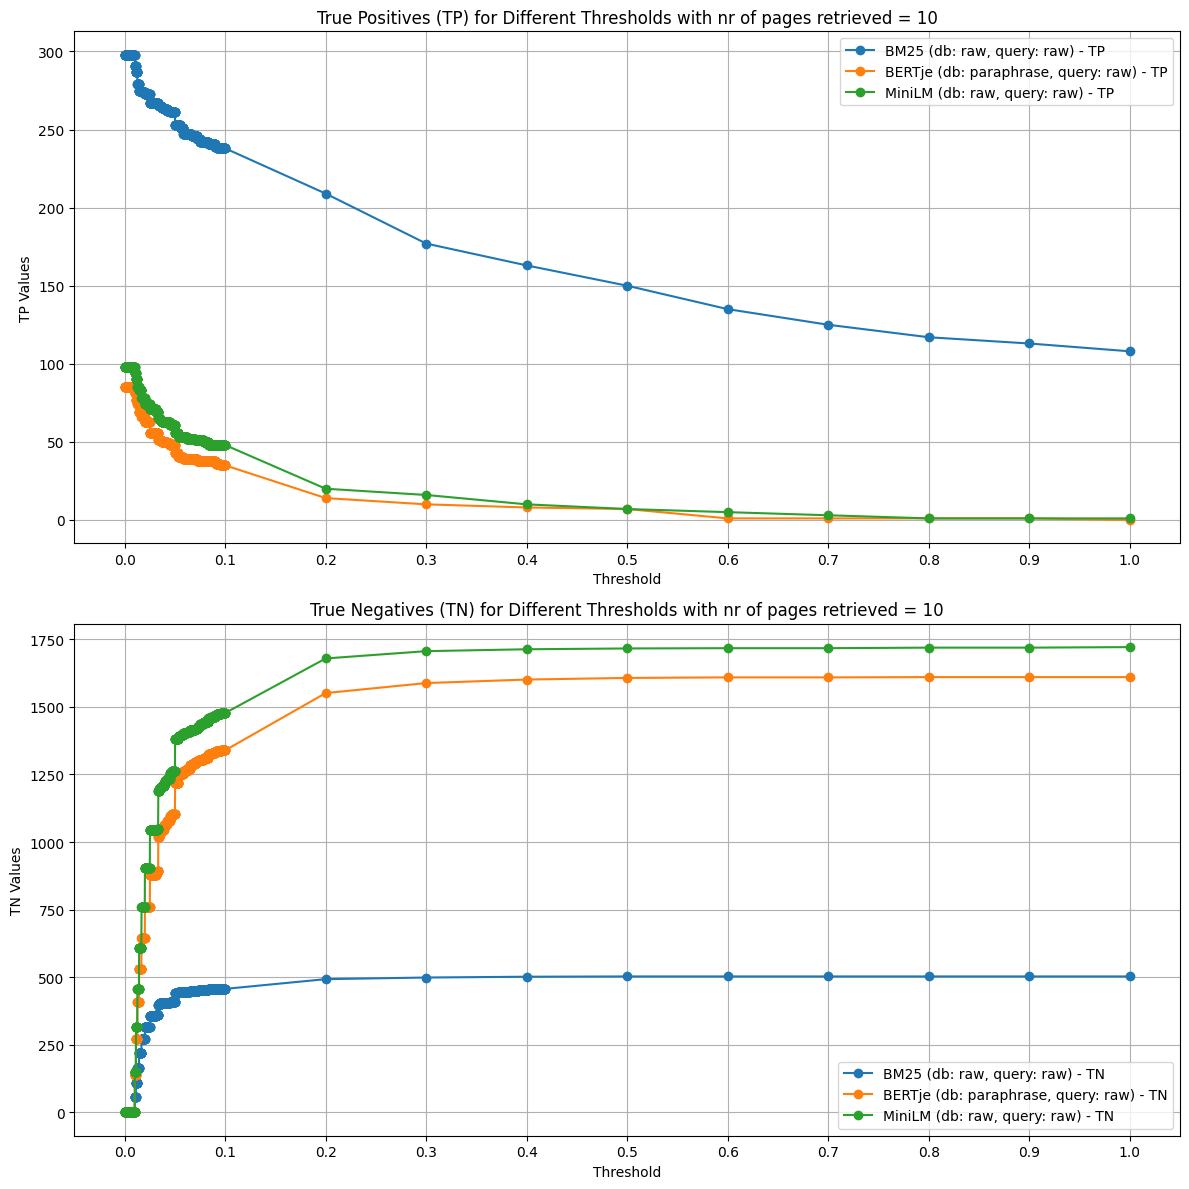

<Figure size 800x600 with 0 Axes>

In [3]:
dossier_id_limits = [10]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Use the correct datasets
woo_datasets = [woo_data_1, woo_data_2, woo_data_3]
dataset_names = ["BM25 (db: raw, query: raw)", "BERTje (db: paraphrase, query: raw)", "MiniLM (db: raw, query: raw)"]

for i in dossier_id_limits:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    for dataset, dataset_name in zip(woo_datasets, dataset_names):
        # Process each dataset for the current dossier ID limit `i`
        result = process_map(dataset, i)
        
        # Create a DataFrame for the result
        results_df = pd.DataFrame(result)
        
        # Plot TP in the first subplot (ax1)
        ax1.plot(results_df['threshold'], results_df['tp'], marker='o', label=f'{dataset_name} - TP')
        
        # Plot TN in the second subplot (ax2)
        ax2.plot(results_df['threshold'], results_df['tn'], marker='o', label=f'{dataset_name} - TN')

    # Customize the first subplot (True Positives)
    ax1.set_title(f'True Positives (TP) for Different Thresholds with nr of pages retrieved = {i}')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('TP Values')
    ax1.set_xticks(thresholds)
    ax1.grid(True)
    ax1.legend()

    # Customize the second subplot (True Negatives)
    ax2.set_title(f'True Negatives (TN) for Different Thresholds with nr of pages retrieved = {i}')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('TN Values')
    ax2.set_xticks(thresholds)
    ax2.grid(True)
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(8, 6))


      threshold   tp   fn  fp   tn
1000        0.2  209   89  10  493
1001        0.3  177  121   4  499
1002        0.4  163  135   1  502
1003        0.5  150  148   0  503
1004        0.6  135  163   0  503
1005        0.7  125  173   0  503
1006        0.8  117  181   0  503
1007        0.9  113  185   0  503
1008        1.0  108  190   0  503
      threshold  tp  fn  fp    tn
1000        0.2  14  71  60  1551
1001        0.3  10  75  23  1588
1002        0.4   8  77  10  1601
1003        0.5   7  78   4  1607
1004        0.6   1  84   2  1609
1005        0.7   1  84   2  1609
1006        0.8   1  84   1  1610
1007        0.9   1  84   1  1610
1008        1.0   0  85   1  1610
      threshold  tp  fn  fp    tn
1000        0.2  20  78  45  1679
1001        0.3  16  82  18  1706
1002        0.4  10  88  11  1713
1003        0.5   7  91   8  1716
1004        0.6   5  93   7  1717
1005        0.7   3  95   7  1717
1006        0.8   1  97   5  1719
1007        0.9   1  97   5  1719
1008

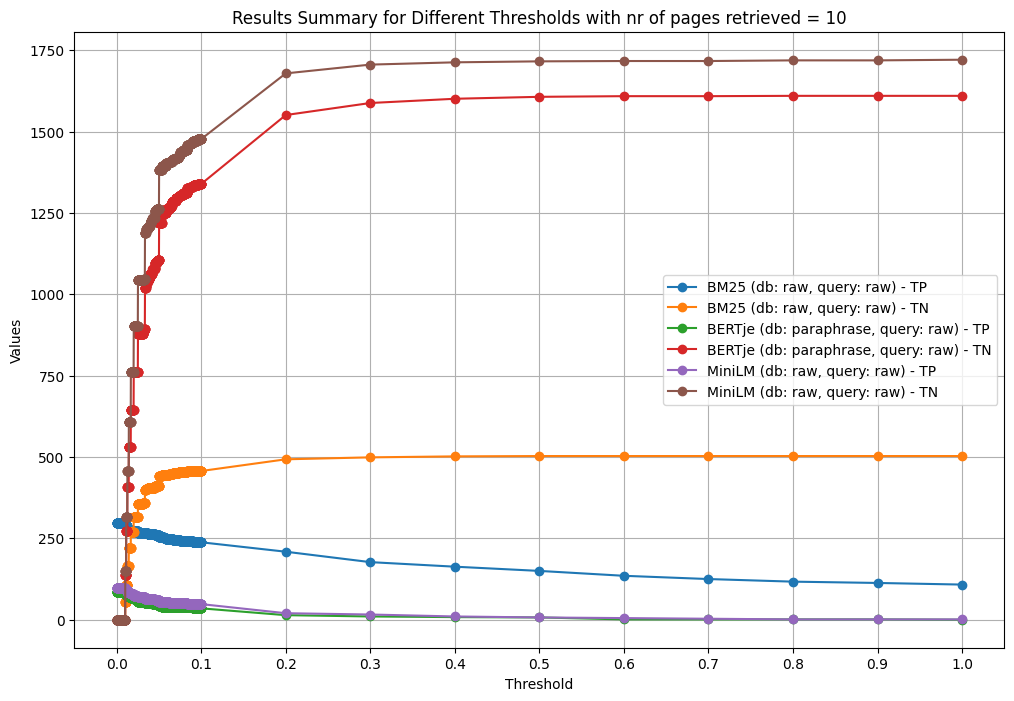

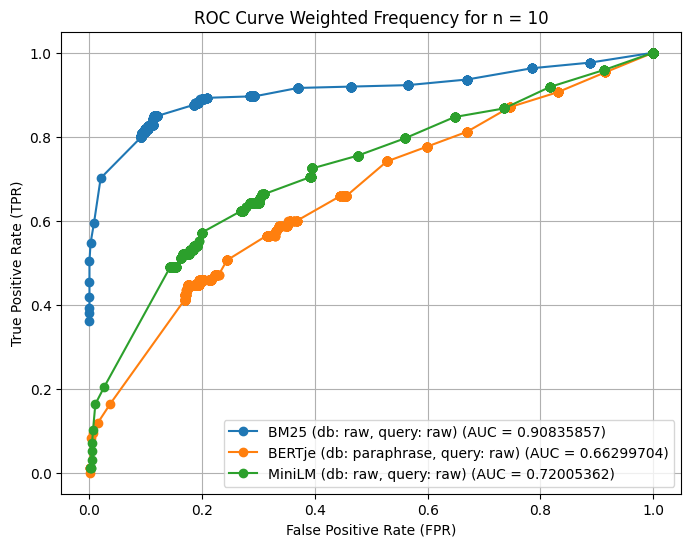

In [20]:
dossier_id_limits = [10]
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Use the correct datasets
woo_datasets = [woo_data_1, woo_data_2, woo_data_3]
dataset_names = ["BM25 (db: raw, query: raw)", "BERTje (db: paraphrase, query: raw)", "MiniLM (db: raw, query: raw)"]

for i in dossier_id_limits:
    plt.figure(figsize=(12, 8))

    results_per_dataset = {}
    
    # Process each dataset once
    for dataset, dataset_name in zip(woo_datasets, dataset_names):
        # Process each dataset for the current dossier ID limit `i` and store the result
        result = process_map(dataset, i)
        results_per_dataset[dataset_name] = result
        
        # Create a DataFrame for the result
        results_df = pd.DataFrame(result)
        # total = results_df['tp'].iloc[0] + results_df['tn'].iloc[0] + results_df['fp'].iloc[0] + results_df['fn'].iloc[0]
        # results_df['tp_percentage'] = (results_df['tp'] / (results_df['tp'] + results_df['fn'])) * 100
        # results_df['tn_percentage'] = results_df['tn'] / (results_df['tn'] + results_df['fn'])

        # Plot only TP and TN for each dataset
        plt.plot(results_df['threshold'], results_df['tp'], marker='o', label=f'{dataset_name} - TP')
        plt.plot(results_df['threshold'], results_df['tn'], marker='o', label=f'{dataset_name} - TN')
        print(results_df.iloc[1000:])

    plt.title(f'Results Summary for Different Thresholds with nr of pages retrieved = {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Values')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(8, 6))
    
    for dataset_name, result in results_per_dataset.items():
        # Calculate TPR and FPR
        tpr = [d['tp'] / (d['tp'] + d['fn']) for d in result]
        fpr = [(d['fp'] / (d['fp'] + d['tn']) if (d['fp'] + d['tn']) != 0 else 0) for d in result]
        
        # Calculate AUC for the result
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve for each dataset
        plt.plot(fpr, tpr, marker='o', label=f'{dataset_name} (AUC = {roc_auc:.8f})')

    plt.title(f'ROC Curve Weighted Frequency for n = {i}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()


In [15]:
results_df

,threshold,tp,fn,fp,tn,tp_percentage,tn_percentage
0,0.0000,98,0,1724,0,0.053787,0.000000
1,0.0001,98,0,1724,0,0.053787,0.000000
2,0.0002,98,0,1724,0,0.053787,0.000000
3,0.0003,98,0,1724,0,0.053787,0.000000
4,0.0004,98,0,1724,0,0.053787,0.000000
...,...,...,...,...,...,...,...
1004,0.6000,5,93,7,1717,0.002744,0.942371
1005,0.7000,3,95,7,1717,0.001647,0.942371
1006,0.8000,1,97,5,1719,0.000549,0.943469
1007,0.9000,1,97,5,1719,0.000549,0.943469
